In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
sns.set_style('whitegrid')

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

from scipy import stats

In [5]:
# I am going to work with the player df, and concentrate on the raptor stats, not the predator (which are predictions).
# a reasonable target for now would be the war columnns
# first I'll clean the data a bit

df_player = pd.read_csv('data/historical_RAPTOR_by_player.csv')
print('df_player cols :  ' ,  df_player.columns)

df = df_player[['player_name', 'player_id', 'season', 'poss', 'mp', 'raptor_offense',
       'raptor_defense', 'raptor_total', 'war_total', 'war_reg_season',
       'war_playoffs', 'pace_impact']]


In [6]:
df.isnull().sum()
# just one null value in pace_impact

player_name       0
player_id         0
season            0
poss              0
mp                0
raptor_offense    0
raptor_defense    0
raptor_total      0
war_total         0
war_reg_season    0
war_playoffs      0
pace_impact       1
dtype: int64

In [7]:
df.nunique()
# there are more ids than names

player_name        3442
player_id          3464
season               45
poss               6415
mp                 3598
raptor_offense    18553
raptor_defense    18552
raptor_total      18553
war_total         18550
war_reg_season    18540
war_playoffs       8330
pace_impact       18542
dtype: int64

In [8]:
df.groupby('player_name')['player_id'].nunique().sort_values().tail(20)
df[df['player_name'] == 'Glen Rice']
# it seems that there a few players with the same name
# we'll trust that the player_id is a good distinctive between different players
# and that two id for one name is because the players are named the same

,player_name,player_id,season,poss,mp,raptor_offense,raptor_defense,raptor_total,war_total,war_reg_season,war_playoffs,pace_impact
13947,Glen Rice,ricegl01,1990,4919,2311,-2.809117,-0.519353,-3.328469,-0.681837,-0.681837,0.000000,-0.032185
13948,Glen Rice,ricegl01,1991,5537,2646,-0.609174,-0.006316,-0.615490,2.884085,2.884085,0.000000,0.086674
13949,Glen Rice,ricegl01,1992,6424,3126,2.073958,-0.561902,1.512056,6.764471,6.921369,-0.156898,-0.106299
13950,Glen Rice,ricegl01,1993,6144,3082,0.943388,-0.074404,0.868983,5.689930,5.689930,0.000000,-0.011900
13951,Glen Rice,ricegl01,1994,6297,3194,2.430118,0.819855,3.249973,9.774483,9.346251,0.428232,-0.071752
13952,Glen Rice,ricegl01,1995,5900,3014,3.639946,-0.002511,3.637435,9.805816,9.805816,0.000000,-0.157176
13953,Glen Rice,ricegl01,1996,6065,3142,3.093041,-0.658377,2.434663,8.287371,8.287371,0.000000,-0.267197
13954,Glen Rice,ricegl01,1997,6528,3499,4.035984,-1.202997,2.832987,9.937278,9.251019,0.686258,-0.516895
13955,Glen Rice,ricegl01,1998,6857,3664,2.261625,-0.929810,1.331814,7.636716,6.686706,0.950010,-0.394452
13956,Glen Rice,ricegl01,1999,2489,1292,2.249545,-1.412263,0.837282,2.376010,1.707741,0.668269,-0.336709


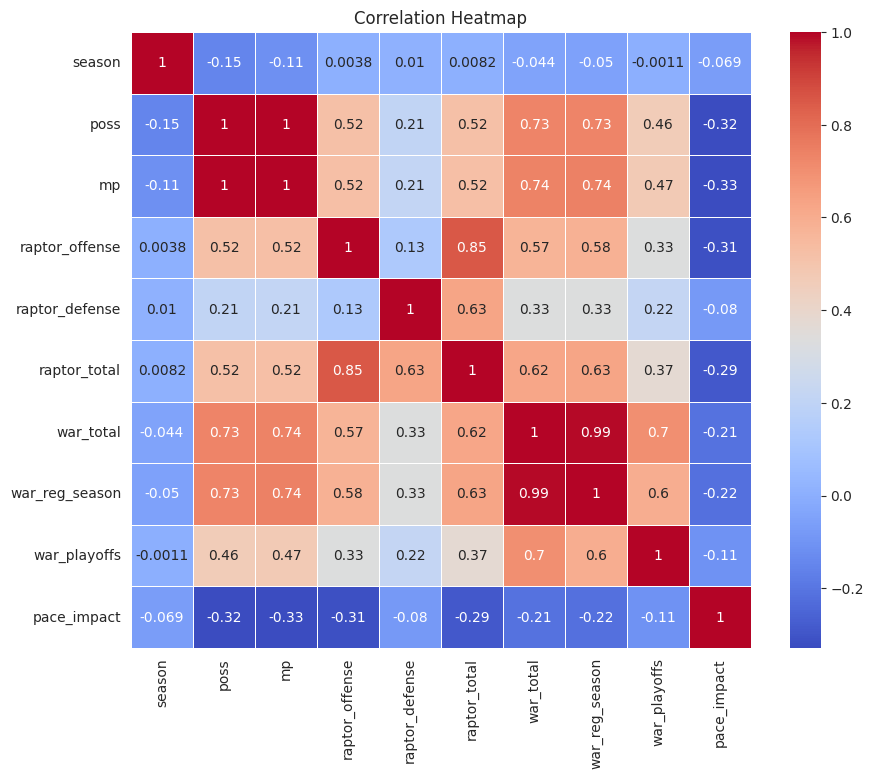

In [9]:
# Calculate the correlation matrix
correlation_matrix = df.corr()

# Create the heatmap
plt.figure(figsize=(10, 8))  # Set the size of the plot
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()
# raptor total, mp, poss seem to have high correlation with war_total

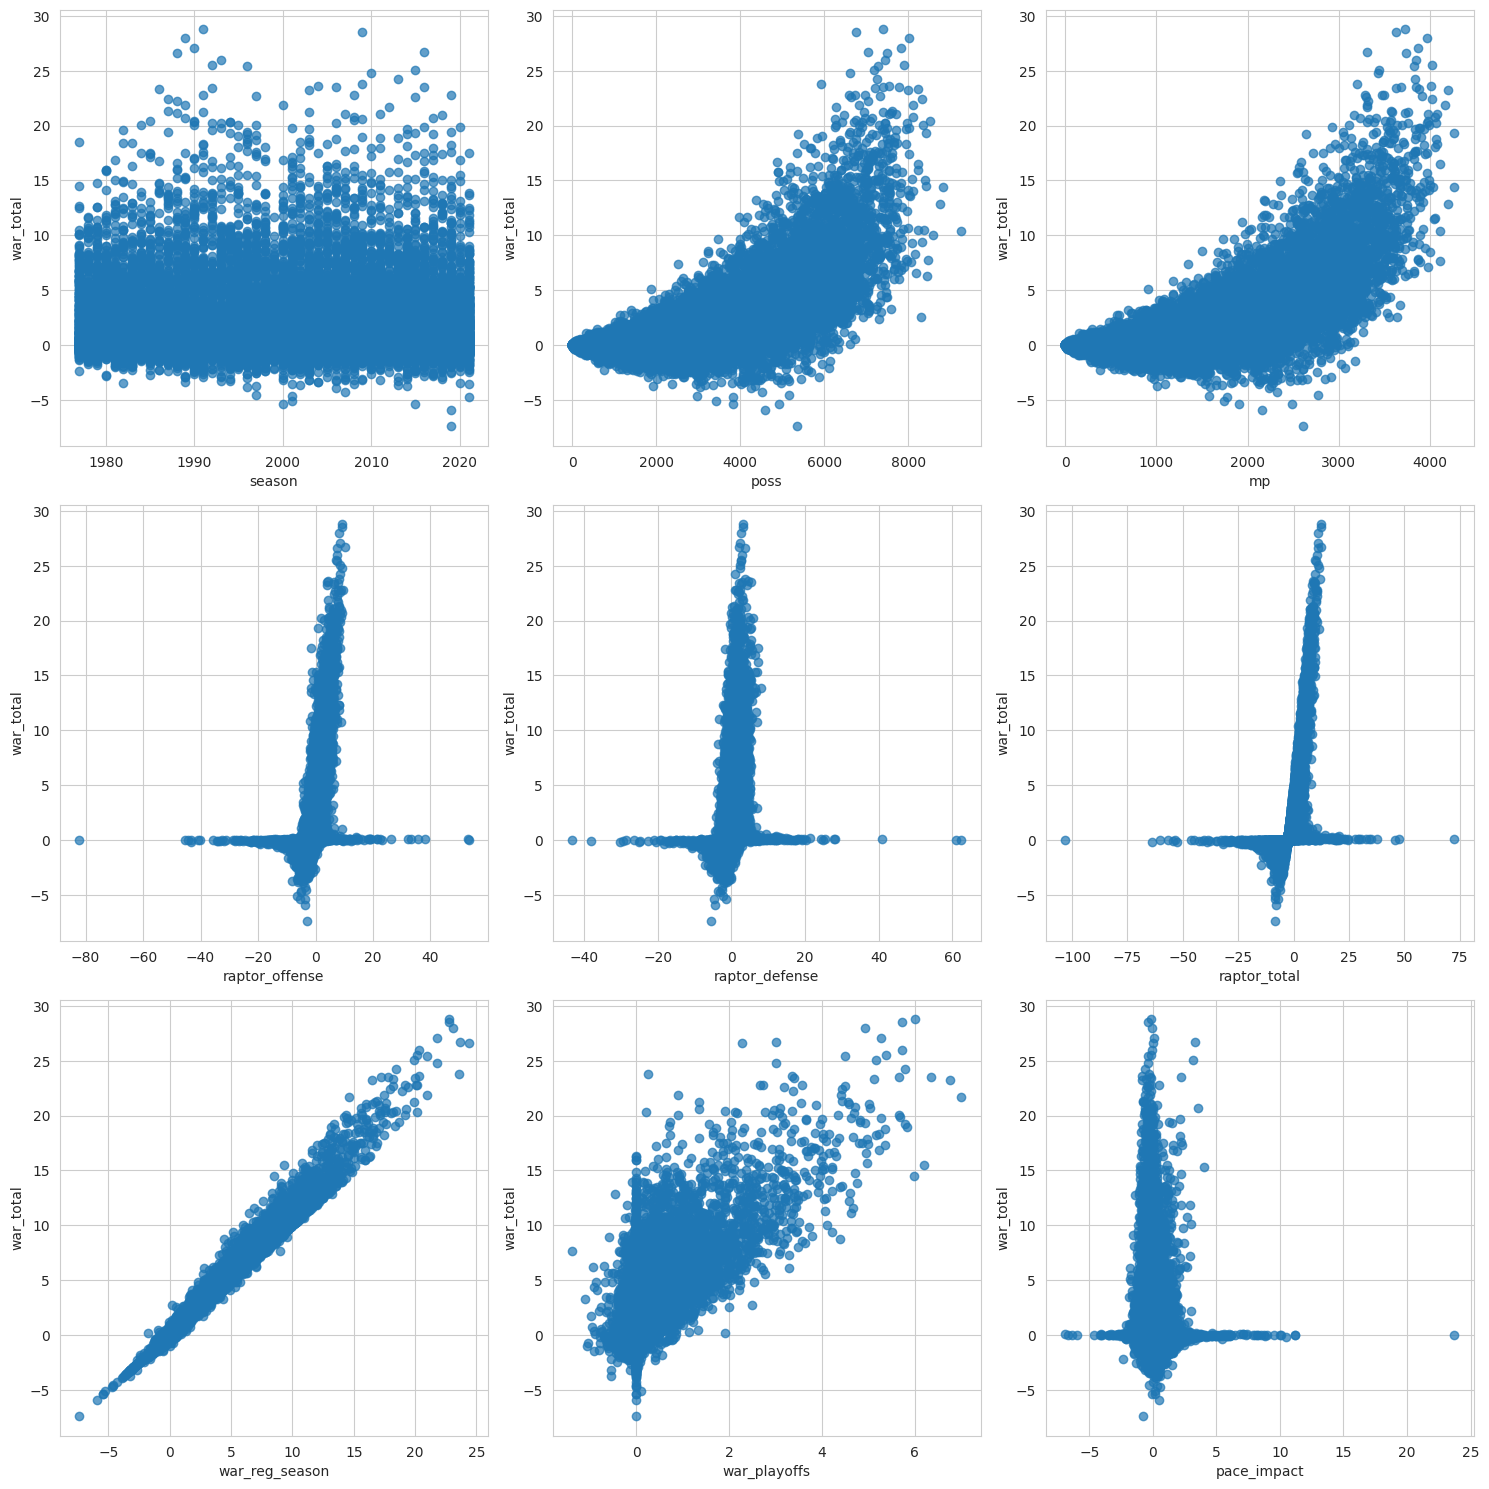

In [10]:
# I am going to target war_total
# scatter war_total against all other features

# Filter only numeric features to avoid errors
# Filter numeric columns and exclude 'war_total'
numeric_features = df.select_dtypes(include='number').drop(columns=['war_total']).columns

# Set up the subplots
n_features = len(numeric_features)  # Exclude 'war_total'
n_cols = 3
n_rows = 3

f, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 15))
axs = axs.flatten()  # Flatten the 2D array of axes

# Plot 'war_total' against other numeric features
for feature, ax in zip(numeric_features, axs):
    if feature != 'war_total':
        ax.scatter(df[feature], df['war_total'], alpha=0.7)
        ax.set_xlabel(feature)
        ax.set_ylabel('war_total')



plt.tight_layout()
plt.show()


I'll just keep war_total, raptor_total, pace impact. Also mp and poss. The relationships for mp and poss are clearly some polynomial dependance. raptor_total, pace impact have some underlying groups of behaviour. In particular, this may explain why the correlation for pace_impact is low: there is a dependance, but it is not linear.

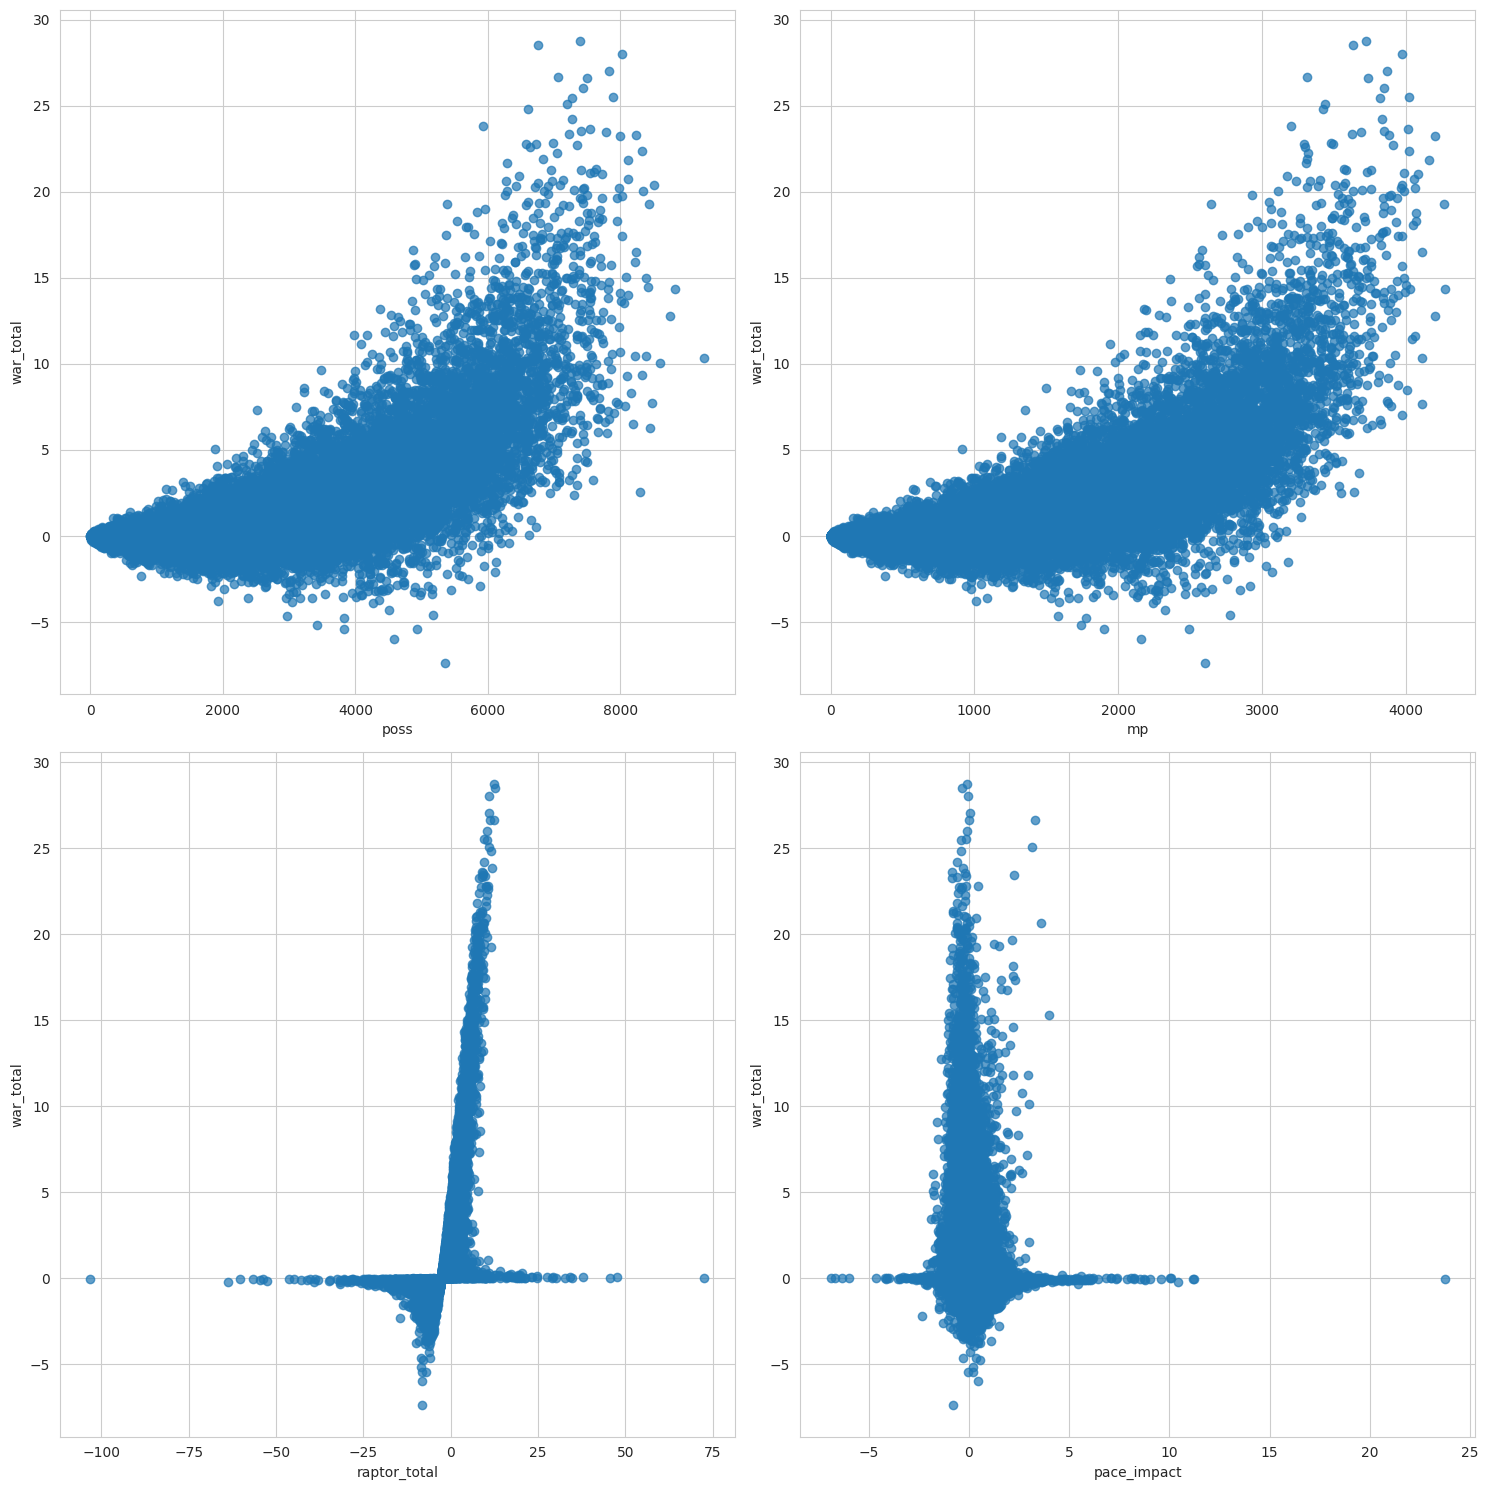

In [19]:
# I'll just keep war_total, raptor_total, pace impact. Also mp and poss.
df = df[['player_name',	'player_id','poss',	'mp' ,	'raptor_total',	'war_total',	'pace_impact',]]
# Filter only numeric features to avoid errors
# Filter numeric columns and exclude 'war_total'
numeric_features = df.select_dtypes(include='number').drop(columns=['war_total']).columns

# Set up the subplots
n_features = len(numeric_features)  # Exclude 'war_total'
n_cols = 2
n_rows = 2

f, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 15))
axs = axs.flatten()  # Flatten the 2D array of axes

# Plot 'war_total' against other numeric features
for feature, ax in zip(numeric_features, axs):
    if feature != 'war_total':
        ax.scatter(df[feature], df['war_total'], alpha=0.7)
        ax.set_xlabel(feature)
        ax.set_ylabel('war_total')

plt.tight_layout()
plt.show()

I'll try out clustering with k-means in the dimensions of raptor_total, war_total, and poss, to see if there are distinct groups there 

/home/lpancotto/.pyenv/versions/lewagon/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/lpancotto/.pyenv/versions/lewagon/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/lpancotto/.pyenv/versions/lewagon/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/lpancotto/.pyenv/versions/lewagon/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1

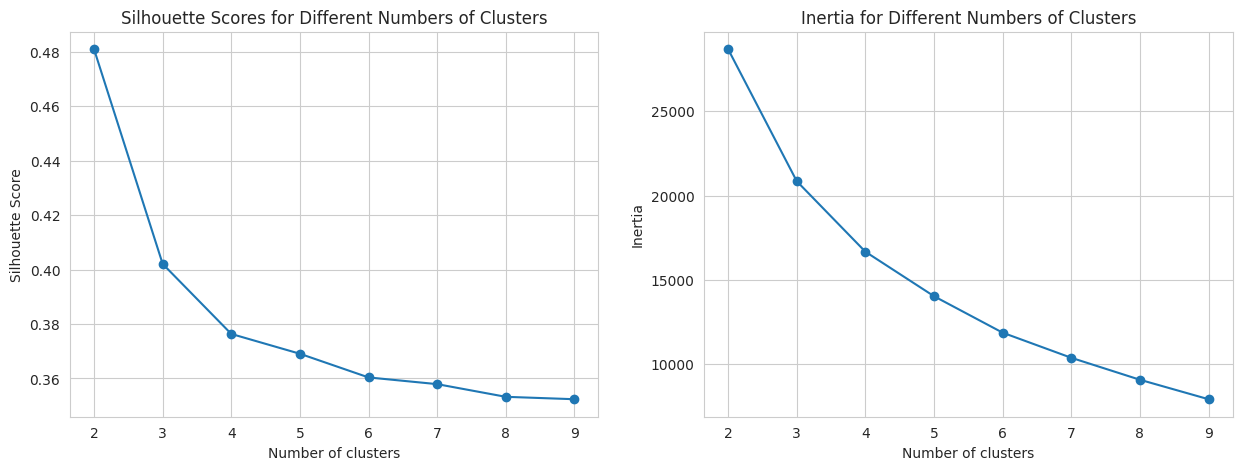

In [13]:
# 1. Scale the three features: 'raptor_total', 'war_total', 'poss'
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[['raptor_total', 'war_total', 'poss']])

# 2. Initialize lists to store inertia and silhouette scores
inertia = []
silhouette_scores = []

# 3. Loop over different numbers of clusters (k)
for k in range(2, 10):  # start from 2 clusters since silhouette score is undefined for 1 cluster
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X_scaled)

    # Calculate inertia (sum of squared distances to cluster centers)
    inertia.append(kmeans.inertia_)

    # Calculate silhouette score for each k
    score = silhouette_score(X_scaled, kmeans.labels_)
    silhouette_scores.append(score)

# 4. Plot both inertia and silhouette scores side by side
f, axs = plt.subplots(ncols=2, figsize=(15,5))

# Plot silhouette scores
axs[0].plot(range(2, 10), silhouette_scores, marker='o')
axs[0].set_xlabel('Number of clusters')
axs[0].set_ylabel('Silhouette Score')
axs[0].set_title('Silhouette Scores for Different Numbers of Clusters')

# Plot inertia
axs[1].plot(range(2, 10), inertia, marker='o')
axs[1].set_xlabel('Number of clusters')
axs[1].set_ylabel('Inertia')
axs[1].set_title('Inertia for Different Numbers of Clusters')

plt.show()

k=2 seems reasonable. As expected the cases with less possesion or minutes played are not so significant to war total, and their raptor stat doesnt really but them in a good or bad position there.

/home/lpancotto/.pyenv/versions/lewagon/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


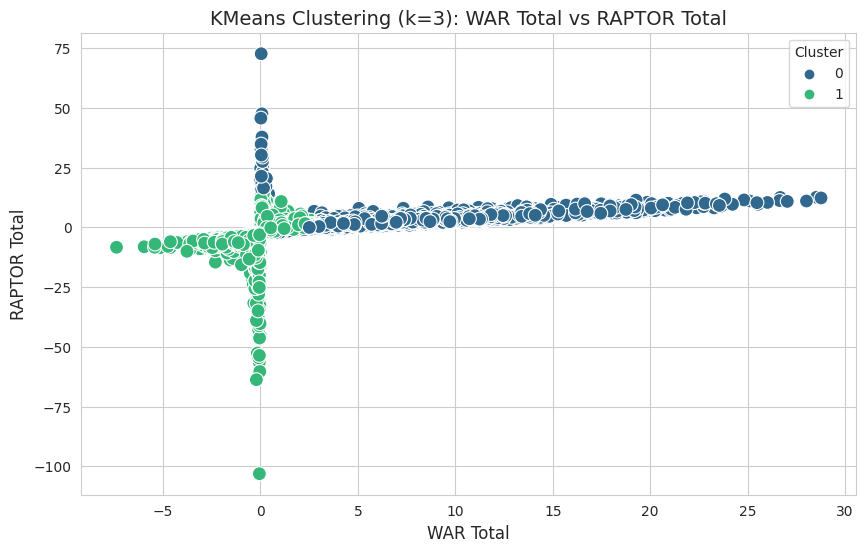

In [14]:
# 1. Scale the three features: 'raptor_total', 'war_total', 'poss'
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[['raptor_total', 'war_total', 'poss']])

# 2. Perform KMeans clustering with k = 3
kmeans = KMeans(n_clusters=2, random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)  # Save cluster labels in the dataframe

# 3. Create scatter plot of war_total vs raptor_total with hue showing clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='war_total', y='raptor_total', hue='cluster', palette='viridis', data=df, s=100)

# 4. Add plot labels and title
plt.title('KMeans Clustering (k=2): WAR Total vs RAPTOR Total', fontsize=14)
plt.xlabel('WAR Total', fontsize=12)
plt.ylabel('RAPTOR Total', fontsize=12)
plt.legend(title='Cluster')
plt.show()

this isn't really useful. Looking back at raptor vs posession, there is a simple idea that might be more effective than clustering. Raptor is a stat every 100 posessions. So if posessions are low for a case, that stat is'treally significant. And this can be seen in the large dispersion of points for low poss, and the change in behaviour when poss is reasonable.

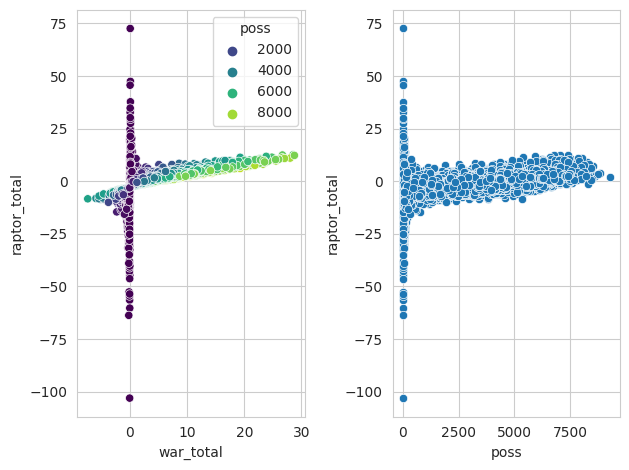

In [20]:
f,axs = plt.subplots(ncols= 2)
sns.scatterplot(x=df['war_total'], y=df['raptor_total'], hue=df['poss'], palette='viridis', ax=axs[0])
sns.scatterplot(x=df['poss'], y=df['raptor_total'], palette='viridis', ax=axs[1])
plt.tight_layout()
# we see the behaviour change for low posession

I will divide the cases in those with low and high posession. I need to  decide where to put the threshold.

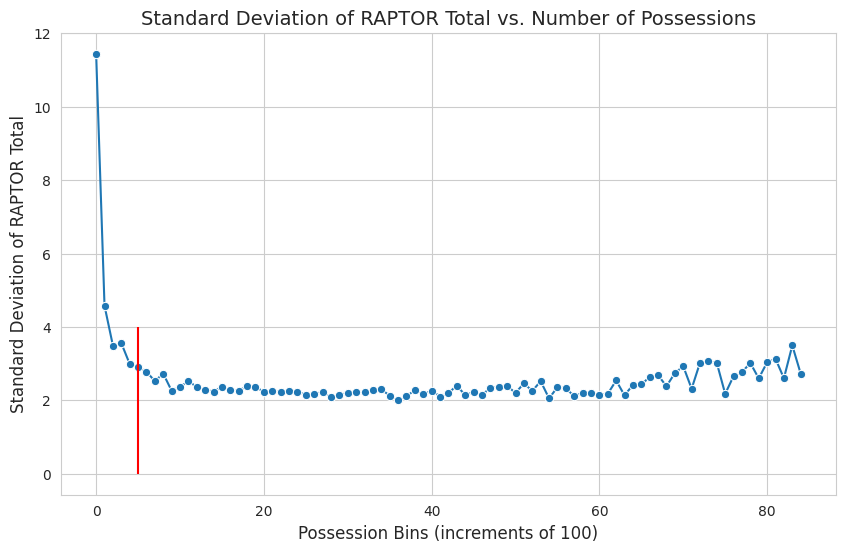

In [16]:


# Bin the 'poss' into intervals and compute the standard deviation of 'raptor_total' in each bin
df['poss_bin'] = pd.cut(df['poss'], bins=np.arange(0, df['poss'].max(), step=100))  # Bin by every 100 possessions

# Calculate mean and standard deviation of raptor_total within each bin
bin_stats = df.groupby('poss_bin')['raptor_total'].agg(['mean', 'std']).reset_index()

# Plot the standard deviation of raptor_total as a function of possession bins
plt.figure(figsize=(10, 6))
sns.lineplot(x=bin_stats.index, y='std', data=bin_stats, marker='o')

# Labels and title
plt.title('Standard Deviation of RAPTOR Total vs. Number of Possessions', fontsize=14)
plt.xlabel('Possession Bins (increments of 100)', fontsize=12)
plt.ylabel('Standard Deviation of RAPTOR Total', fontsize=12)
plt.vlines(5,0,4,colors='r')
plt.show()
# at around 500 poss the variation stabalizes


/tmp/ipykernel_1903/2097876135.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['significant_poss'] = (df['poss'] >= 500).astype(int)
/tmp/ipykernel_1903/2097876135.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['significant_poss'] = df['significant_poss'].astype('category')


<AxesSubplot:xlabel='pace_impact', ylabel='war_total'>

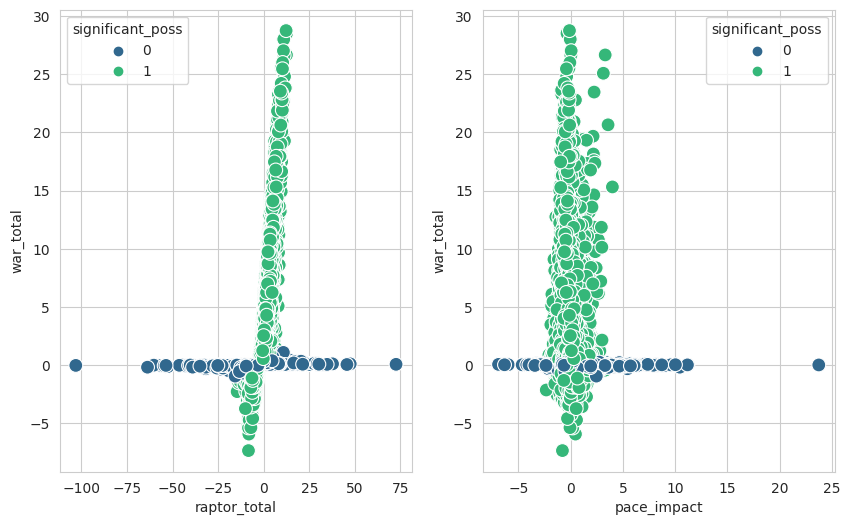

In [27]:
# finally,
# I'll just keep war_total, raptor_total, pace impact. Also mp and poss
df = df_player[['player_name',	'player_id','poss',	'mp',	'raptor_total',	'war_total',	'pace_impact']]
# I will 'clusterize' by hand, dividing the data in two groups: less and more than 500 poss
df['significant_poss'] = (df['poss'] >= 500).astype(int)
# Convert 'significant_poss' to categorical type
df['significant_poss'] = df['significant_poss'].astype('category')

f,axs = plt.subplots(ncols = 2 , figsize=(10, 6))
sns.scatterplot(x='raptor_total', y='war_total', hue='significant_poss', palette='viridis', data=df, s=100, ax = axs[0])
sns.scatterplot(x='pace_impact' , y='war_total',hue='significant_poss', palette='viridis', data=df, s=100, ax = axs[1])

# the cross shape is separated in the behaviour for low posession cases and the behaviour with high posession cases,
# and this seems to give two distinct dependancies for war_total.